# Stack-overflow Question's Programming Language Prediction

## Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Dropout, Input, Embedding, BatchNormalization, concatenate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing Questions.csv file

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Dataset/Questions.csv",encoding="ISO-8859-1")
data.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
data.drop(["OwnerUserId","CreationDate","ClosedDate","Score"], axis=1, inplace=True)
data.head()

,Id,Title,Body
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
def clean_html_tags(data):
    regex = re.compile('<.*?>')
    return re.sub(regex, '', data)

data['Body'] = data['Body'].apply(clean_html_tags)
data.head()

In [ ]:
data.to_csv('Clean_Questions.csv', index=False)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Dataset/Clean_Questions.csv")
data.head()

,Id,Title,Body
0,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...
1,90,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...
2,120,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...
3,180,Function for creating color wheels,This is something I've pseudo-solved many time...
4,260,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...


## Pre-processing Tags.csv file & Exploring the top 10 famous language questions asked on Stack Overflow

In [ ]:
data_tags = pd.read_csv('/content/drive/MyDrive/Dataset/Tags.csv')
data_tags.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [ ]:
data.shape

(1264216, 3)

In [ ]:
data_tags.shape

(3750994, 2)

In [ ]:
pd.DataFrame(data_tags['Tag'].value_counts()).head(15)

,Tag
javascript,124155
java,115212
c#,101186
php,98808
android,90659
jquery,78542
python,64601
html,58976
c++,47591
ios,47009


In [ ]:
tag_counts = {
    'javascript':124155,
    'java':115212,
    'c#':101186,
    'php':98808,
    'python':64601,
    'html':58976,
    'c++':47591,
    'css':42308,
    'sql':35782,
    'objective-c':26922,
}

## Indexing the programming language for Prediction at last

In [ ]:
# Index for language Prediction

index = {
    'javascript':0,
    'java':1,
    'c#':2,
    'php':3,
    'python':4,
    'html':5,
    'c++':6,
    'css':7,
    'sql':8,
    'objective-c':9,
}

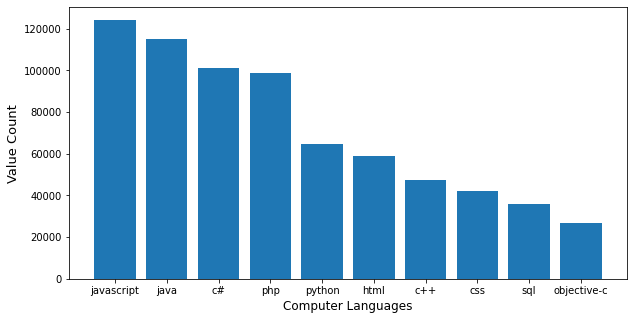

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(range(len(tag_counts)), list(tag_counts.values()))
plt.xticks(range(len(tag_counts)), list(tag_counts.keys()))
plt.xlabel("Computer Languages", fontsize=12)
plt.ylabel("Value Count", fontsize=13)
plt.show()

In [ ]:
lang_top10 = data_tags[data_tags.Tag.isin(list(tag_counts.keys()))]

lang_top10.shape

(715541, 2)

## Merging Questions & Language Tags Data file

In [ ]:
total = pd.merge(data, lang_top10, on = "Id")
total.head()

,Id,Title,Body,Tag
0,120,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...,sql
1,260,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,c#
2,330,Should I use nested classes in this case?,I am working on a collection of classes used f...,c++
3,650,Automatically update version number,I would like the version property of my applic...,c#
4,930,How do I connect to a database and loop over a...,What's the simplest way to connect and query a...,c#


In [ ]:
total.shape

(715541, 4)

## x will be the Predictor & y will be the Target Variable

In [ ]:
x = total.drop(columns=['Tag'])
y = pd.get_dummies(total['Tag'])    # Encoding the Categorical Values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Model building based on ONLY the Title of the Question

## Tokenizing, Sequencing & Padding (upto 20 length) the Title training-dataset of the Question

In [ ]:
tok = Tokenizer()
tok.fit_on_texts(x_train['Title'])
sequences_train = tok.texts_to_sequences(x_train['Title'])
sequences_train = sequence.pad_sequences(sequences_train, maxlen = 20)
sequences_train

array([[    0,     0,     0, ...,    72,    11,  1143],
       [    0,     0,     0, ...,  1576, 15768,  1758],
       [    0,     0,     0, ...,   524,    12,    68],
       ...,
       [    0,     0,     0, ...,    20,   535,   220],
       [    0,     0,     0, ...,  2856,  1481,   817],
       [    0,     0,     0, ...,    41,     2,    19]], dtype=int32)

In [ ]:
vocab_title = len(tok.index_word.keys())
vocab_title

78280

## Tokenizing, Sequencing & Padding (upto 20 length) the Title testing-dataset of the Question

In [ ]:
sequences_test = tok.texts_to_sequences(x_test['Title'])
sequences_test = sequence.pad_sequences(sequences_test, maxlen = 20)

## Model based on ONLY the Title of the Question

In [ ]:
model = Sequential()

model.add(Input(shape=[20]))
model.add(Embedding(vocab_title+1, 2000, input_length=20, mask_zero=True))

model.add(GRU(300))

model.add(Dense(400,activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(150, activation='relu'))

model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 2000)          156686000 
_________________________________________________________________
gru (GRU)                    (None, 300)               2071800   
_________________________________________________________________
dense (Dense)                (None, 400)               120400    
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 400)               1600      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               60150     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Fitting the Prediction model based on Title of the Question

In [ ]:
history = model.fit(sequences_train, y_train, epochs=5, batch_size=800)

Train on 572432 samples
Epoch 1/5
572432/572432 [==============================] - 559s 973us/sample - loss: 0.9888 - accuracy: 0.6522
Epoch 2/5
572432/572432 [==============================] - 555s 966us/sample - loss: 0.7887 - accuracy: 0.7234
Epoch 3/5
572432/572432 [==============================] - 554s 968us/sample - loss: 0.7209 - accuracy: 0.7335
Epoch 4/5
572432/572432 [==============================] - 536s 980us/sample - loss: 0.6780 - accuracy: 0.7632
Epoch 5/5
572432/572432 [==============================] - 570s 990us/sample - loss: 0.6436 - accuracy: 0.7921


# Model building based on ONLY the Body of the Question

## Tokenizing, Sequencing & Padding (upto 600 length) the Body training-dataset of the Question

In [ ]:
tok1 = Tokenizer()
tok1.fit_on_texts(x_train['Body'])
sequences_train_body = tok1.texts_to_sequences(x_train['Body'])

In [ ]:
vocab_body = len(tok1.index_word.keys())
vocab_body

1608267

In [ ]:
sequences_train_body = sequence.pad_sequences(sequences_train_body, maxlen = 600)
sequences_train_body

array([[    0,     0,     0, ..., 39626,   435,   145],
       [    0,     0,     0, ...,   214,  1446, 11829],
       [    0,     0,     0, ...,   354,   343,    91],
       ...,
       [    0,     0,     0, ...,    41,   968,   384],
       [    0,     0,     0, ...,  2038,   185,  3437],
       [    0,     0,     0, ...,    57,    23,  2288]], dtype=int32)

## Tokenizing, Sequencing & Padding (upto 600 length) the Body testing-dataset of the Question

In [ ]:
sequences_test_body = tok.texts_to_sequences(x_test['Body'])
sequences_test_body = sequence.pad_sequences(sequences_test_body, maxlen = 600)

## Model based on ONLY the Body of the Question

In [ ]:
model = Sequential()

model.add(Input(shape=[600]))
model.add(Embedding(vocab_body+1, 170, input_length=600, mask_zero=True))

model.add(GRU(200))

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(150, activation='relu'))

model.add(Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 170)          272628320 
_________________________________________________________________
gru_1 (GRU)                  (None, 200)               223200    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 400)               1600      
_________________________________________________________________
dense_4 (Dense)              (None, 150)               60150     
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Fitting the Prediction model based on Body of the Question

In [ ]:
history1 = model.fit(sequences_train_body, y_train, epochs=5, batch_size=800)

Train on 572432 samples
Epoch 1/5
572432/572432 [==============================] - 1063s 2ms/sample - loss: 0.9575 - accuracy: 0.6634
Epoch 2/5
572432/572432 [==============================] - 1059s 2ms/sample - loss: 0.5570 - accuracy: 0.7932
Epoch 3/5
572432/572432 [==============================] - 1058s 2ms/sample - loss: 0.4617 - accuracy: 0.8152
Epoch 4/5
572432/572432 [==============================] - 1059s 2ms/sample - loss: 0.3942 - accuracy: 0.8298
Epoch 5/5
572432/572432 [==============================] - 1068s 2ms/sample - loss: 0.3437 - accuracy: 0.8417


# Concatening the Prediction model based Title & Body of the Question. This model will prediction the Programming langauge based on the Title & Body of the Question

In [ ]:
title_input = Input(shape=[20])
title_embed = Embedding(vocab_title + 1, 2000, input_length=20, mask_zero=True)(title_input)
gru_t = GRU(300)(title_embed)

#title_output = Dense(10, activation='softmax')(gru_t)   

body_input = Input(shape=[600]) 
body_embed = Embedding(vocab_body + 1, 170, input_length=600, mask_zero=True)(body_input)
gru_b = GRU(200)(body_embed)
    
concat = concatenate([gru_t, gru_b])

dense1 = Dense(400, activation='relu')(concat)
dp = Dropout(0.5)(dense1)
bn = BatchNormalization()(dp) 
dense2 = Dense(150, activation='relu')(bn)
    
output = Dense(10, activation='softmax')(dense2)
    
model = Model(inputs=[title_input, body_input], outputs=[output])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 600)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 2000)     156716000   input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 600, 170)     273259870   input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Fitting the Prediction model based on Title + Body of the Question.

## Highest Accuracy achieved is 97%

In [ ]:
history2 = model.fit([sequences_train, sequences_train_body], y_train, epochs=5, batch_size=800)

Train on 572432 samples
Epoch 1/5
572432/572432 [==============================] - 1798s 3ms/sample - loss: 0.7794 - accuracy: 0.7242
Epoch 2/5
572432/572432 [==============================] - 1776s 3ms/sample - loss: 0.4705 - accuracy: 0.8165
Epoch 3/5
572432/572432 [==============================] - 1779s 3ms/sample - loss: 0.3980 - accuracy: 0.8532
Epoch 4/5
572432/572432 [==============================] - 1774s 3ms/sample - loss: 0.3443 - accuracy: 0.9137
Epoch 5/5
572432/572432 [==============================] - 1780s 3ms/sample - loss: 0.2996 - accuracy: 0.9738


# Saving the Final Model.

In [ ]:
model.save("/content/drive/MyDrive/model.h5")

print("Saved model to disk")

# Dumping(saving) the Title & Body tokenizer so time needed for prediction will be less.

In [ ]:
from pickle import dump
from pickle import load
from keras.models import load_model

In [ ]:
# dump(tok, open(r'/content/drive/MyDrive/tokenizer_with_title.pkl', 'wb'))

In [ ]:
# dump(tok1, open(r'/content/drive/MyDrive/tokenizer_with_body.pkl', 'wb'))

# Loading the Title & Body tokenizer & Model file for faster Prediction

In [ ]:
tokenizer_with_title = load(open(r'/content/drive/MyDrive/tokenizer_with_title.pkl', 'rb'))

In [ ]:
tokenizer_with_body = load(open(r'/content/drive/MyDrive/tokenizer_with_body.pkl', 'rb'))

In [ ]:
model = load_model("/content/drive/MyDrive/model.h5")

# Prediction of the Programming language tag based on the User Question.

In [ ]:
def process_test_data(post_title, post_body):
  
  dataFrame = pd.DataFrame(columns=["post_title", "post_body"])
  dataFrame['post_title'] = [post_title]
  dataFrame['post_body'] = [post_body]
  
  sequences_test_title = tokenizer_with_title.texts_to_sequences(dataFrame['post_title'])
  sequences_test_title = sequence.pad_sequences(sequences_test_title, maxlen = 20)

  sequences_test_body = tokenizer_with_body.texts_to_sequences(dataFrame['post_body'])
  sequences_test_body = sequence.pad_sequences(sequences_test_body, maxlen = 600)

  return sequences_test_title, sequences_test_body

In [ ]:
post_title = "Numpy — Compute Maximum of Each Column of a Matrix"
post_body = """
Given an n x m matrix, I want to determine the maximum of each column and return a 1D vector (i.e. list) with this data. How can I do this?
I've searched the web and can't seem to find a method of doing this. I know I can do this with a simple loop but I'm trying to find a more elegant approach.
"""

[sequences_test_title, sequences_test_body] = process_test_data(post_title, post_body)

In [ ]:
pred_with_titles_and_body = model.predict([sequences_test_title, sequences_test_body])

In [ ]:
print(np.argmax(pred_with_titles_and_body))

4


In [ ]:
for key, values in index.items():
  if np.argmax(pred_with_titles_and_body) == values:
    print(f"Predicted language { key }({pred_with_titles_and_body[0][np.argmax(pred_with_titles_and_body)]*100}%)")

Predicted language python(96.14610075950623%)
